# Milestone 6 : Lagrange points and their stability.

In [1]:
import matplotlib.pyplot as plt
from numpy import  array, zeros, concatenate, linalg, any, linspace, shape, log, reshape,sqrt
import import_ipynb
import Numerical_schemes
import Simple_Math
import Stability

## 1. Write a high order embedded Runge-Kutta method.

In [172]:
def RangeKutta45(U,t1,t2,F):

        dt = t2 - t1

        k1 = dt*F(U)
        k2 = dt*F(U + (2/9)*k1)
        k3 = dt*F(U + (1/12)*k1 + (1/4)*k2)
        k4 = dt*F(U + (69/128)*k1 + (-243/128)*k2 + (135/64)*k3)
        k5 = dt*F(U + (-17/12)*k1 + (27/4)*k2 + (-27/5)*k3 + (16/15)*k4)
        k6 = dt*F(U + (65/432)*k1 + (-5/16)*k2 + (13/16)*k3 + (4/27)*k4 + (5/144)*k5)
        
        U1 = U + (47/450)*k1 + (0)*k2 + (12/25)*k3 + (32/225)*k4 + (1/30)*k5 + (6/25)*k6
        Error = linalg.norm(k1*((47/450)-(1/9)) + k2*((0)-(0)) + k3*((12/25)-(9/20)) + k4*((32/225)-(16/45)) + k5*((1/30)-(1/12)) + k6*((6/25)-(0)))

        return U1, Error


In [4]:
def Embedded_RK45(U0,t1,tf,F,dt_0=0.1,tol = 1e-6):
    Error_0 = 0.0

    dt_values = [dt_0]      #We define lists to store the values: variable size!
    t_values = [t1]        
    U_values = [U0]         
    E_values = [Error_0]    

    

    t2 = t1 + dt_0
    i = 0
    dt = dt_0
    

    while t1 < tf:
        
        U, Error  = RangeKutta45(U_values[i],t1,t2,F)       #Calculate U and E in i+1
       

        if Error < 1e-16:   
            Error = 1e-16
         
        if Error <= tol:    
            U_values.append(U)
            t_values.append(t2)
            E_values.append(Error)
            dt_values.append(dt)
            i += 1
            #print(f"Step {i+1}: t = {t2}, dt = {dt}, Error = {Error}")

            t1 = t_values[i]
            t2 = t1 + dt_values[i]

        else:                                    
            dt_values[i] = dt_values[i]*(tol/Error)**(1/5)
            dt = dt_values[i]
            t1 = t_values[i]
            t2 = t1 + dt
            #print("!!!!"f"Step {i+1}: t = {t2}, dt = {dt}, Error = {Error}")
            
    return array(U_values), array(t_values), array(E_values), array(dt_values),i   



In [5]:
def NBodyProblem_embedded(Nb,Nc,r0,v0,t0,tf,Nv=2): 

    U0 = zeros((Nb * Nc * Nv))  
    Us = reshape(U0, (Nb, Nc, Nv))
    r = reshape(Us[:,:,0],(Nb,Nc))  # Positions
    v = reshape(Us[:,:,1], (Nb,Nc))  # Velocities


    for i in range(Nb):    #We build the vector U with the initial conditions
        r[i,:] = r0[i,:]
        v[i,:] = v0[i,:]
    

    def Function(X): 
        Xs = reshape(X, (Nb, Nc, Nv))
        xr = reshape(Xs[:,:,0],(Nb,Nc))  # Positions
        xv = reshape(Xs[:,:,1], (Nb,Nc))  # Velocities

        F = zeros((Nb * Nc * Nv))
        Fs = reshape(F, (Nb, Nc, Nv)) 
        drdt = reshape(Fs[:,:,0],(Nb,Nc)) #Velocities
        dvdt = reshape(Fs[:,:,1],(Nb,Nc)) #Accelerations

        for i in range(Nb):
            drdt[i,:] = xv[i,:]
            for j in range(Nb):
                if i!=j: 
                    distancia_vect =  (xr[j,:]-xr[i,:])
                    dist = linalg.norm(xr[j,:]-xr[i,:])
                    #if dist < 1:
                    #    dvdt[i,:] = dvdt[i,:] + (distancia_vect/(100*dist**3))
                    #else :
                    dvdt[i,:] = dvdt[i,:] + (distancia_vect/(dist**3))
        return F
    

    U, tiempo, E, dt2, iterations = Embedded_RK45(U0,t0,tf,Function)

    Nt = len(tiempo)

    U_sol =reshape(U,(Nt,Nb,Nc,Nv))
    rsol = reshape(U_sol[:,:,:,0],(Nt,Nb,Nc))  # Positions
    vsol = reshape(U_sol[:,:,:,1],(Nt,Nb,Nc))  # Positions

    return rsol,vsol


## 2. Write function to simulate the circular restricted three body problem.

In [6]:
def restricted_3bodyProblem_F(U): 

    M1 = 5.972e24  #EARTH MASS
    M2 = 7.348e22  #MOON MASS

    mu = M2/(M1+M2)

    F = zeros(4)

    r1 = sqrt((U[0]+mu)**2 + U[1]**2)
    r2 = sqrt((U[0]-1+mu)**2 + U[1]**2)
 
    F[0] = U[2]
    F[1] = U[3]
    F[2] = 2*U[3] + U[0] - (((1-mu) * (U[0]+mu)) / (r1**3)) - (mu * (U[0]- (1-mu)) / (r2**3))
    F[3] = -2*U[2] + U[1] - (((1-mu) * U[1]) / (r1**3)) - (mu * U[1] / (r2**3))
 

    return F
    


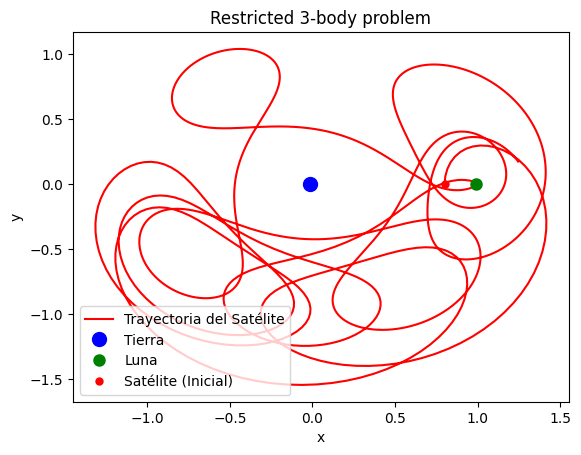

In [61]:
U0 = array([0.8, 0.0, 0.0, 0.6])   #Initial state vector: [x,y,vx,vy]
t1 = 0.0                        #Initial time
tf = 60.0                       #Final time

r_sat1, t1, E1, dt, it = Embedded_RK45(U0,t1,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)

mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon

plt.plot(r_sat1[:,0], r_sat1[:,1],"red", label='Trayectoria del Satélite')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Tierra')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Luna')
plt.plot(U0[0], U0[1], 'ro', markersize=5, label='Satélite (Inicial)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Restricted 3-body problem')
plt.legend()
plt.show()


##  3. Determination of the Lagrange points F(U) = 0.

In [ ]:
xL1 = array([0.1, 0, 0, 0])  
xL2 = array([1.1, 0, 0, 0])  
xL3 = array([-1.1, 0, 0, 0])  
xL4 = array([0.5, 0.5, 0, 0])  
xL5 = array([0.5, -0.5, 0, 0])  

L1_point = Simple_Math.Newton(restricted_3bodyProblem_F,xL1)
L2_point = Simple_Math.Newton(restricted_3bodyProblem_F,xL2)
L3_point = Simple_Math.Newton(restricted_3bodyProblem_F,xL3)
L4_point = Simple_Math.Newton(restricted_3bodyProblem_F,xL4)
L5_point = Simple_Math.Newton(restricted_3bodyProblem_F,xL5)

## 4. Stability of the Lagrange points: L1, L2, L3, L4, L5.

### L1 POINT

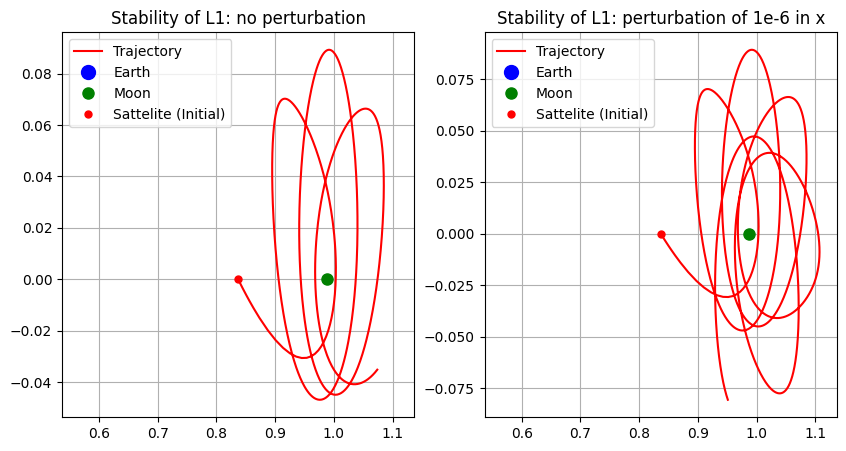

Can bee seen on the plots that the Lagrange point L1 is unstable


In [125]:
U0 = L1_point                                       #No perturbation
U1 = L1_point + array([0.000001, 0.0, 0.0, 0.0])     #Perturbation on x

t0 = 0.0                     
tf = 10.0                  

r_sat1, t1, E1, dt, it = Embedded_RK45(U0,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat2, t1, E1, dt, it = Embedded_RK45(U1,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)

mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(r_sat1[:,0], r_sat1[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5, label='Sattelite (Initial)')
plt.title('Stability of L1: no perturbation')
plt.xlim(L1_point[0]-0.3, L1_point[0]+ 0.3)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(r_sat2[:,0], r_sat2[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L1: perturbation of 1e-6 in x')
plt.xlim(L1_point[0]-0.3, L1_point[0]+ 0.3)
plt.legend()
plt.grid(True)

plt.show()

print("Can bee seen on the plots that the Lagrange point L1 is unstable")

### L2 POINT

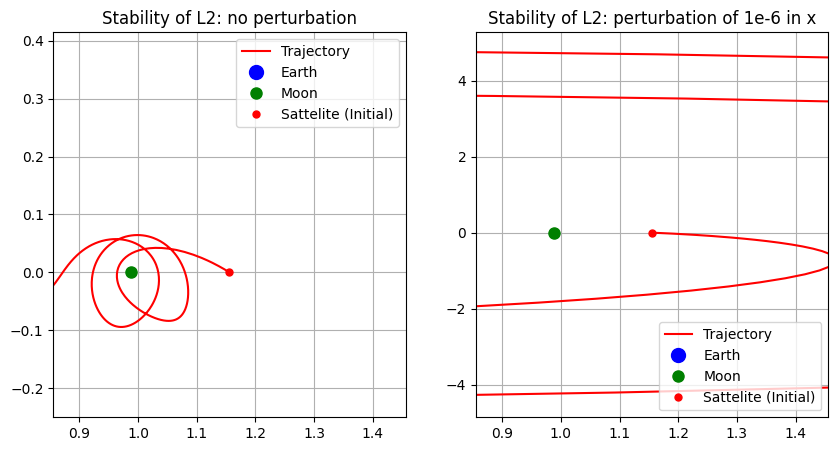

Can bee seen on the plots that the Lagrange point L2 is unstable


In [122]:
U0 = L2_point                                       #No perturbation
U1 = L2_point + array([0.000001, 0.0, 0.0, 0.0])     #Perturbation on x

t0 = 0.0                     
tf = 20.0                  

r_sat1, t1, E1, dt, it = Embedded_RK45(U0,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat2, t1, E1, dt, it = Embedded_RK45(U1,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)

mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(r_sat1[:,0], r_sat1[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5, label='Sattelite (Initial)')
plt.title('Stability of L2: no perturbation')
plt.xlim(L2_point[0]-0.3, L2_point[0]+ 0.3)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(r_sat2[:,0], r_sat2[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L2: perturbation of 1e-6 in x')
plt.xlim(L2_point[0]-0.3, L2_point[0]+ 0.3)
plt.legend()
plt.grid(True)

plt.show()

print("Can bee seen on the plots that the Lagrange point L2 is unstable")

### L3 POINT

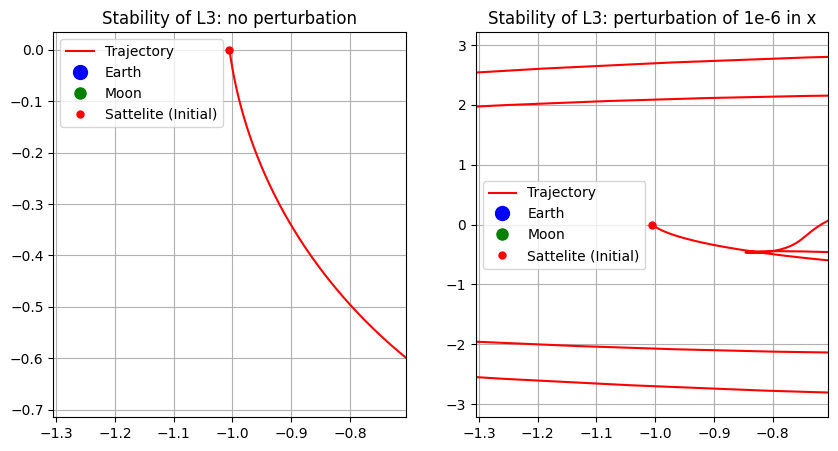

Can bee seen on the plots that the Lagrange point L3 is unstable


In [136]:
U0 = L3_point                                       #No perturbation
U1 = L3_point + array([0.00001, 0.0, 0.0, 0.0])     #Perturbation on x

t0 = 0.0                     
tf = 90.0                  

r_sat1, t1, E1, dt, it = Embedded_RK45(U0,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat2, t1, E1, dt, it = Embedded_RK45(U1,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)

mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(r_sat1[:,0], r_sat1[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5, label='Sattelite (Initial)')
plt.title('Stability of L3: no perturbation')
plt.xlim(L3_point[0]-0.3, L3_point[0]+ 0.3)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(r_sat2[:,0], r_sat2[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L3: perturbation of 1e-6 in x')
plt.xlim(L3_point[0]-0.3, L3_point[0]+ 0.3)
plt.legend()
plt.grid(True)

plt.show()

print("Can bee seen on the plots that the Lagrange point L3 is unstable")

### L4 POINT

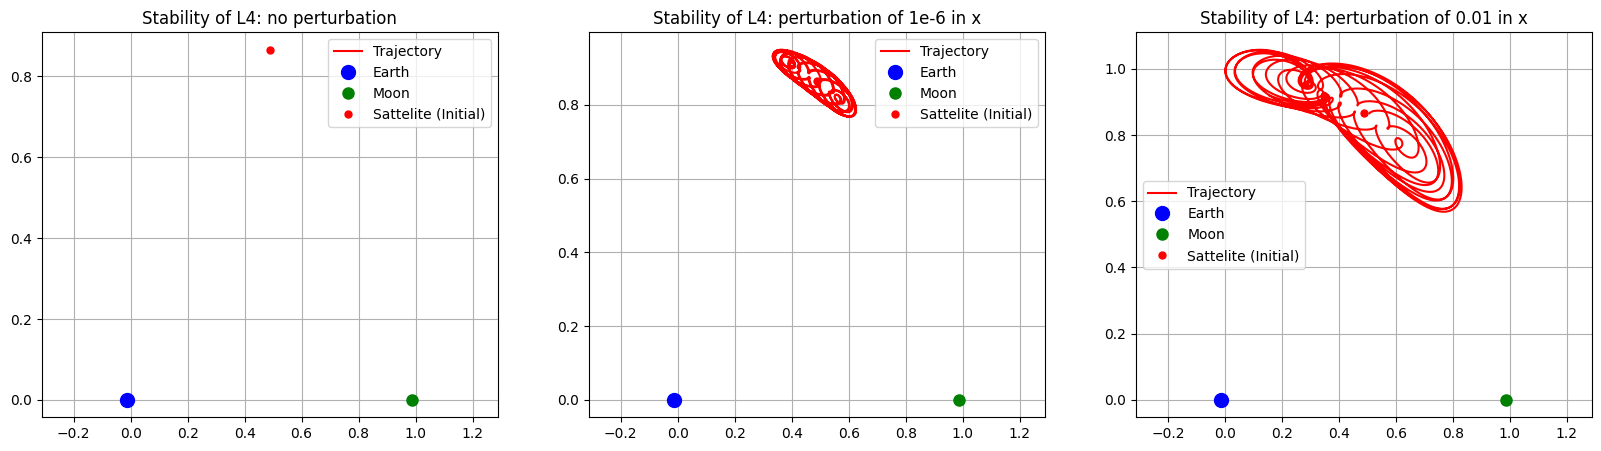

Can bee seen on the plots that the Lagrange point L4 is STABLE


In [ ]:
U0 = L4_point                                       #No perturbation
U1 = L4_point + array([0.01, 0.0, 0.0, 0.0])     #Perturbation on x
U2 = L4_point + array([0.02, 0.0, 0.0, 0.0])     #Perturbation on x

t0 = 0.0                     
tf = 200.0                  

r_sat1, t1, E1, dt, it = Embedded_RK45(U0,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat2, t1, E1, dt, it = Embedded_RK45(U1,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat3, t1, E1, dt, it = Embedded_RK45(U2,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)

mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon


plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(r_sat1[:,0], r_sat1[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5, label='Sattelite (Initial)')
plt.title('Stability of L4: no perturbation')
plt.xlim(L4_point[0]-0.8, L4_point[0]+ 0.8)
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(r_sat2[:,0], r_sat2[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L4: perturbation of 1e-6 in x')
plt.xlim(L4_point[0]-0.8, L4_point[0]+ 0.8)
plt.legend()
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(r_sat3[:,0], r_sat3[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L4: perturbation of 0.01 in x')
plt.xlim(L4_point[0]-0.8, L4_point[0]+ 0.8)
plt.legend()
plt.grid(True)

plt.show()

print("Can bee seen on the plots that the Lagrange point L4 is STABLE inside a certain region")

### L5 POINT

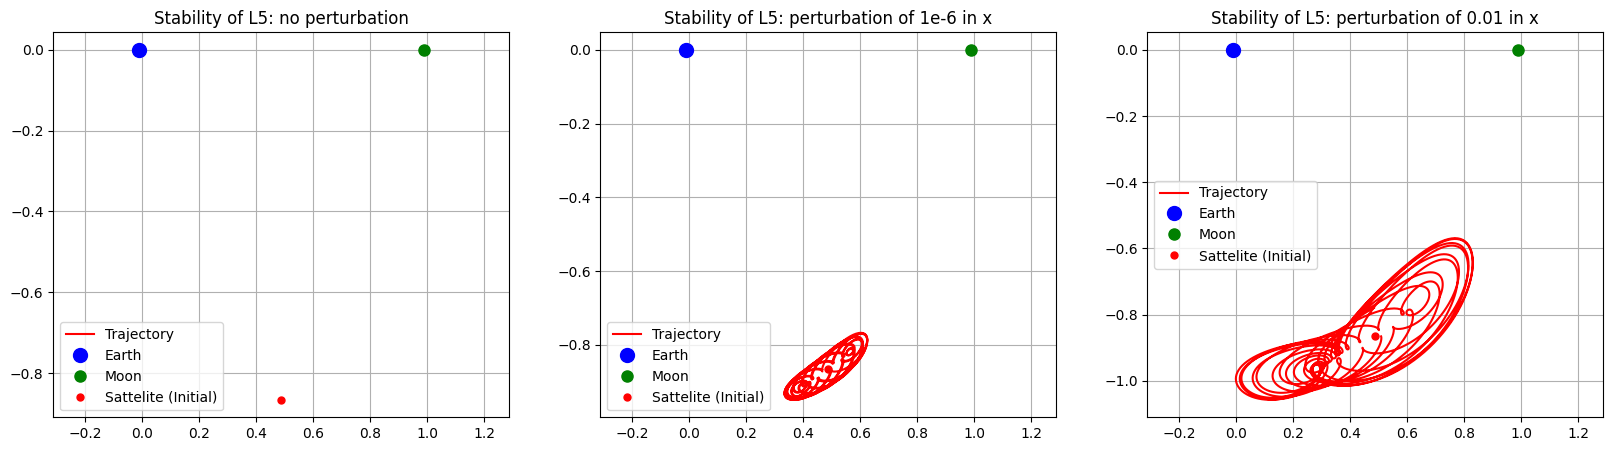

Can bee seen on the plots that the Lagrange point L5 is STABLE inside a certain region


In [157]:
U0 = L5_point                                       #No perturbation
U1 = L5_point + array([0.01, 0.0, 0.0, 0.0])     #Perturbation on x
U2 = L5_point + array([0.02, 0.0, 0.0, 0.0])     #Perturbation on x

t0 = 0.0                     
tf = 200.0                  

r_sat1, t1, E1, dt, it = Embedded_RK45(U0,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat2, t1, E1, dt, it = Embedded_RK45(U1,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)
r_sat3, t1, E1, dt, it = Embedded_RK45(U2,t0,tf,restricted_3bodyProblem_F,dt_0=0.1,tol = 1e-6)

mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon


plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(r_sat1[:,0], r_sat1[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5, label='Sattelite (Initial)')
plt.title('Stability of L5: no perturbation')
plt.xlim(L5_point[0]-0.8, L5_point[0]+ 0.8)
plt.legend()
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(r_sat2[:,0], r_sat2[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L5: perturbation of 1e-6 in x')
plt.xlim(L5_point[0]-0.8, L5_point[0]+ 0.8)
plt.legend()
plt.grid(True)

plt.subplot(1,3,3)
plt.plot(r_sat3[:,0], r_sat3[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U0[0], U0[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L5: perturbation of 0.01 in x')
plt.xlim(L5_point[0]-0.8, L5_point[0]+ 0.8)
plt.legend()
plt.grid(True)

plt.show()

print("Can bee seen on the plots that the Lagrange point L5 is STABLE inside a certain region")

## 5. Orbits around the Lagrange points by means of different temporal schemes.

### 5.1 EULER

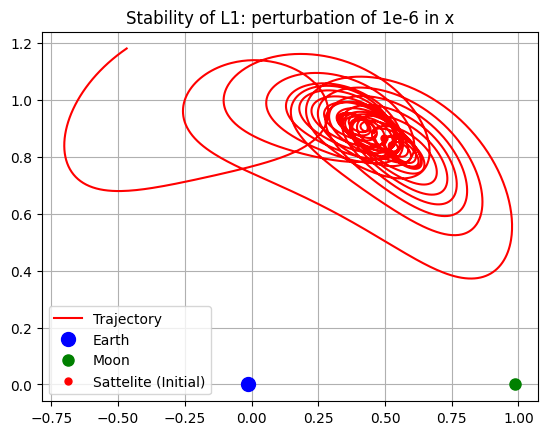

In [ ]:
U1 = L4_point + array([0.01, 0.0, 0.0, 0.0])     #Perturbation on x


t0 = 0.0                     
tf = 220.0   

t = linspace(t0,tf,10000)     

r_sat = Stability.Cauchy_Problem(restricted_3bodyProblem_F,U1,t,Numerical_schemes.Euler)


mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon



plt.plot(r_sat[:,0], r_sat[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U1[0], U1[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L1: perturbation of 0.01 in x')
plt.legend()
plt.grid(True)

plt.show()




### 5.2 INVERSE EULER

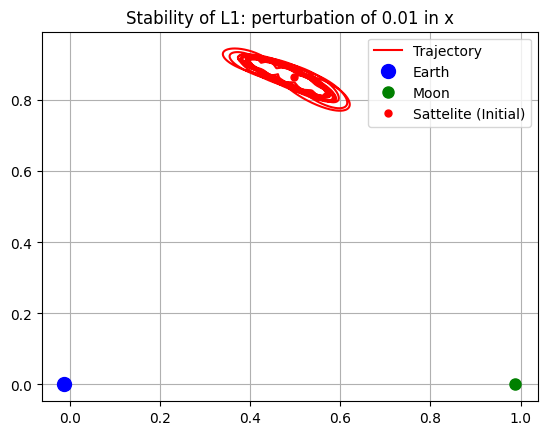

In [202]:
U1 = L4_point + array([0.01, 0.0, 0.0, 0.0])     #Perturbation on x


t0 = 0.0                     
tf = 220.0   

t = linspace(t0,tf,10000)     

r_sat = Stability.Cauchy_Problem(restricted_3bodyProblem_F,U1,t,Numerical_schemes.Inverse_Euler)


mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon



plt.plot(r_sat[:,0], r_sat[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U1[0], U1[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L1: perturbation of 0.01 in x')
plt.legend()
plt.grid(True)

plt.show()




### 5.3 RANGE KUTTA 4

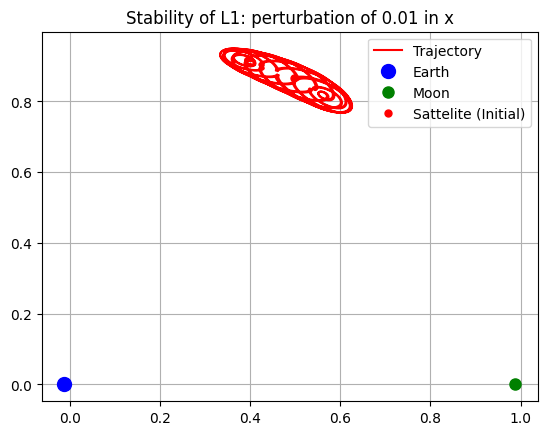

In [201]:
U1 = L4_point + array([0.01, 0.0, 0.0, 0.0])     #Perturbation on x


t0 = 0.0                     
tf = 220.0   

t = linspace(t0,tf,10000)     

r_sat = Stability.Cauchy_Problem(restricted_3bodyProblem_F,U1,t,Numerical_schemes.RangeKutta4)


mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon



plt.plot(r_sat[:,0], r_sat[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U1[0], U1[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L1: perturbation of 0.01 in x')
plt.legend()
plt.grid(True)

plt.show()




### 5.4 CRANK NICOLSON

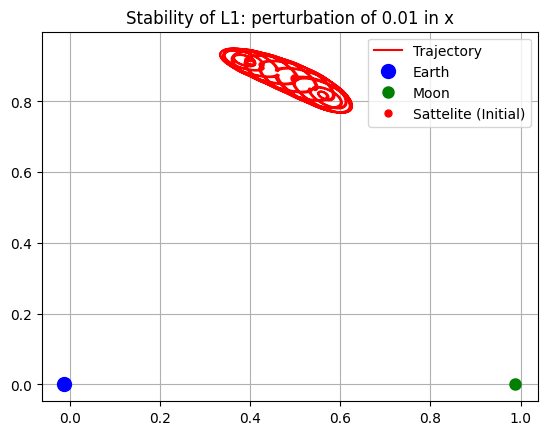

In [203]:
U1 = L4_point + array([0.01, 0.0, 0.0, 0.0])     #Perturbation on x


t0 = 0.0                     
tf = 220.0   

t = linspace(t0,tf,10000)     

r_sat = Stability.Cauchy_Problem(restricted_3bodyProblem_F,U1,t,Numerical_schemes.Crank_Nicolson)


mu = 7.348e22/(5.972e24 + 7.348e22)

pos_tierra1 = array([0-mu,0])   #Position of the Earth
pos_luna1 = array([1 - mu,0])    #Position of the Moon



plt.plot(r_sat[:,0], r_sat[:,1],"red", label='Trajectory')
plt.plot(pos_tierra1[0], pos_tierra1[1], 'bo', markersize=10, label='Earth')
plt.plot(pos_luna1[0], pos_luna1[1], 'go', markersize=8, label='Moon')
plt.plot(U1[0], U1[1], 'ro', markersize=5,label='Sattelite (Initial)')
plt.title('Stability of L1: perturbation of 0.01 in x')
plt.legend()
plt.grid(True)

plt.show()
